
# Galaxy vs. quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

SDSS observed in four bands:
<center>
    <img src="https://github.com/Alice-Palladino/astrostatistics_bicocca_2024/blob/main/working/quasars.png?raw=true" alt="SDSS observations" width="500">
</center>

### Data

The dataset is at solutions/galaxyquasar.csv. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used SQL and want to learn something new it's computing, it's very powerful)

### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy $=0$ and quasar $=1$.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

### Ideas

- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import corner

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [45]:
data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [46]:
usecols = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

u_g = np.array(data.get(usecols[0]) - data.get(usecols[1]))
g_r = np.array(data.get(usecols[1]) - data.get(usecols[2]))
r_i = np.array(data.get(usecols[2]) - data.get(usecols[3]))
i_z = np.array(data.get(usecols[3]) - data.get(usecols[4]))

target = np.array(data.get(usecols[5]))
y = np.empty(shape = u_g.size)     # Class labels

for i, label in enumerate(target):
    if (label == 'GALAXY'): y[i] = 0
    elif (label == 'QSO'): y[i] = 1

We can first explore how, for each color, the quasar and galaxy data are distributed:

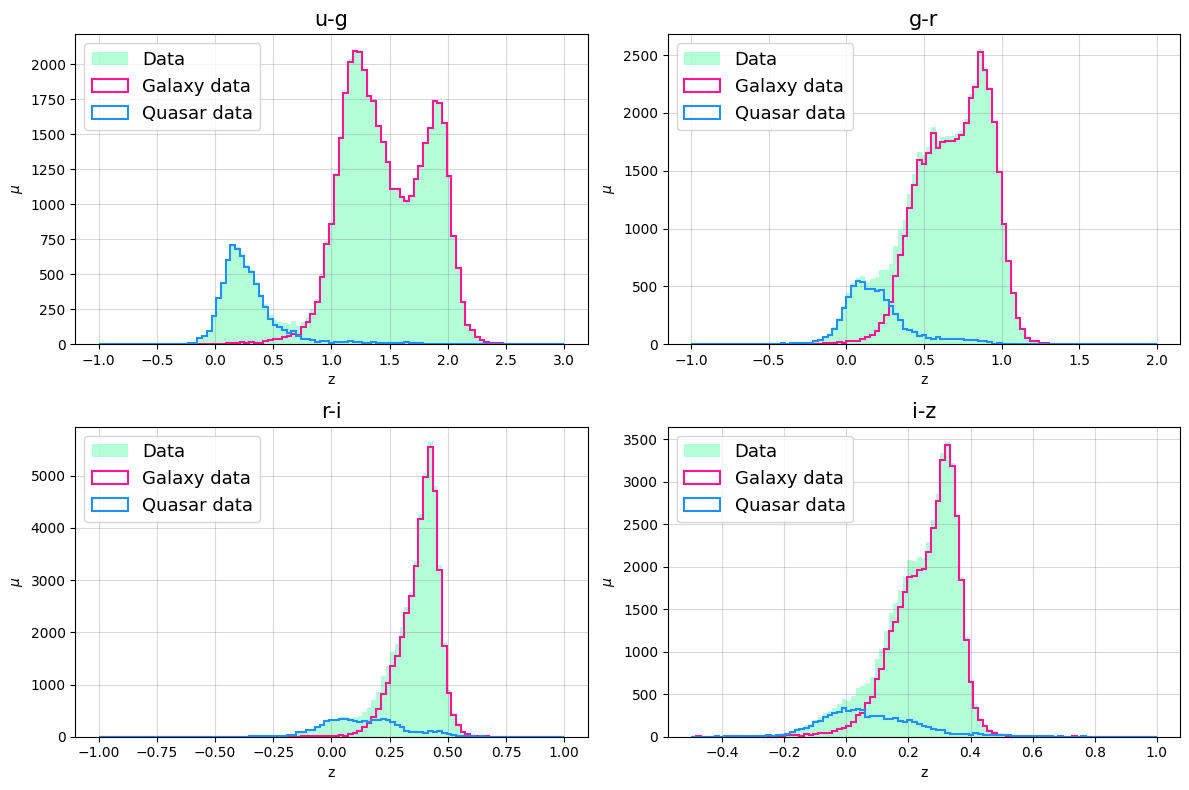

In [47]:
data_array = [u_g, g_r, r_i, i_z]
titles = ['u-g', 'g-r', 'r-i', 'i-z']
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

fig = plt.figure(figsize=(12, 8))
axes = []

for i, col in enumerate(data_array):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    plt.hist(col, bins = bins[i], color = 'springgreen', alpha = 0.3, label = 'Data')
    plt.hist(col[y==0], bins = bins[i], histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    plt.hist(col[y==1], bins = bins[i], histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title(titles[i], fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    ax.legend(loc='upper left', fontsize = 13)

plt.tight_layout()
plt.show()

For the $(u-g)$ data, the distributions are clearly separated; this is not so noticeable for the other colors. 

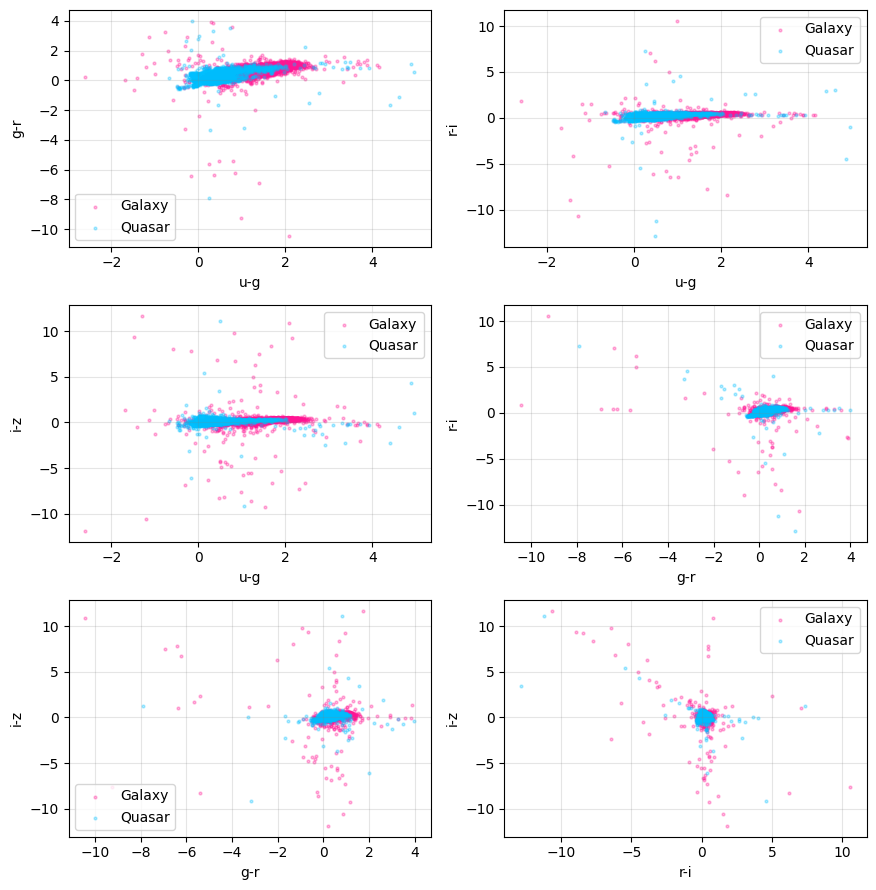

In [48]:
# I could've used corner for the next plots, but the contours were very small and I didn't get a clear idea of the data.

fig, axes = plt.subplots(3, 2, figsize = (9, 9))

axes[0, 0].scatter(u_g[y==0], g_r[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 0].scatter(u_g[y==1], g_r[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 0].grid(c='grey', alpha = 0.2)
axes[0, 0].set_xlabel('u-g')
axes[0, 0].set_ylabel('g-r')
axes[0, 0].legend()

axes[0, 1].scatter(u_g[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 1].scatter(u_g[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 1].grid(c='grey', alpha = 0.2)
axes[0, 1].set_xlabel('u-g')
axes[0, 1].set_ylabel('r-i')
axes[0, 1].legend()


axes[1, 0].scatter(u_g[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 0].scatter(u_g[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 0].grid(c='grey', alpha = 0.2)
axes[1, 0].set_xlabel('u-g')
axes[1, 0].set_ylabel('i-z')
axes[1, 0].legend()

axes[1, 1].scatter(g_r[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 1].scatter(g_r[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 1].grid(c='grey', alpha = 0.2)
axes[1, 1].set_xlabel('g-r')
axes[1, 1].set_ylabel('r-i')
axes[1, 1].legend()

axes[2, 0].scatter(g_r[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 0].scatter(g_r[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 0].grid(c='grey', alpha = 0.2)
axes[2, 0].set_xlabel('g-r')
axes[2, 0].set_ylabel('i-z')
axes[2, 0].legend()

axes[2, 1].scatter(r_i[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 1].scatter(r_i[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 1].grid(c='grey', alpha = 0.2)
axes[2, 1].set_xlabel('r-i')
axes[2, 1].set_ylabel('i-z')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

As noticed before, the plots with $(u-g)$ show a slight bimodality. This suggests that $(u-g)$ could be the most informative feature.


#### Train-test splitting


In [49]:
X=np.array([u_g, g_r, r_i, i_z]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=336)


#### Preliminary work: plotting functions


In [64]:
def single_ROC(X_train, X_test, y_train, y_test, classifier):
    
    # Plots the ROC curves for a classifier trained on the single features
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()

    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with a single feature:\n')

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    for i, col in enumerate(colors):

        clf.fit(X_train[:, i].reshape(-1, 1), y_train)
        y_prob = clf.predict_proba(X_test[:, i].reshape(-1, 1))[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label=col)
        ax[1].plot(fpr, tpr, label=col)

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - single features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.7, 1)
    
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def progressive_ROC(X_train, X_test, y_train, y_test, classifier):
    
    # Plots the ROC curves for a classifier trained on a increasing number of features
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()

    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with multiple features:\n')

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    for i in range(4):

        clf.fit(X_train[:, 0:i+1], y_train)
        y_prob = clf.predict_proba(X_test[:, 0:i+1])[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label= '%i features' % (i+1))
        ax[1].plot(fpr, tpr, label= '%i features' % (i+1))

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - multiple features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.9, 1)
    ax[1].set_xlim(0, 0.5)
    
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color):

    # Defining color
    if (color == 'u-g'): ind = 0
    elif (color == 'g-r'): ind = 1
    elif (color == 'r-i'): ind = 2
    elif (color == 'i-z'): ind = 3

    bins_vec = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]
    bins = bins_vec[ind]
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 8))
    
    axes[0, 0].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 0].hist(X_train[y_train_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 0].hist(X_train[y_train_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 0].grid(c='grey', alpha = 0.2)
    axes[0, 0].set_xlabel(color)
    axes[0, 0].set_title('Predicted labels for train dataset')
    axes[0, 0].legend()
    
    axes[0, 1].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 1].hist(X_train[y_train==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 1].hist(X_train[y_train==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 1].grid(c='grey', alpha = 0.2)
    axes[0, 1].set_xlabel(color)
    axes[0, 1].set_title('True labels for train dataset')
    axes[0, 1].legend()

    axes[1, 0].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 0].hist(X_test[y_test_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 0].hist(X_test[y_test_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 0].grid(c='grey', alpha = 0.2)
    axes[1, 0].set_xlabel(color)
    axes[1, 0].set_title('Predicted labels for test dataset')
    axes[1, 0].legend()
    
    axes[1, 1].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 1].hist(X_test[y_test==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 1].hist(X_test[y_test==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 1].grid(c='grey', alpha = 0.2)
    axes[1, 1].set_xlabel(color)
    axes[1, 1].set_title('True labels for test dataset')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color1, color2):

    # Defining color1
    if (color1 == 'u-g'): ind1 = 0
    elif (color1 == 'g-r'): ind1 = 1
    elif (color1 == 'r-i'): ind1 = 2
    elif (color1 == 'i-z'): ind1 = 3

    # Defining color2
    if (color2 == 'u-g'): ind2 = 0
    elif (color2 == 'g-r'): ind2 = 1
    elif (color2 == 'r-i'): ind2 = 2
    elif (color2 == 'i-z'): ind2 = 3
    
    
    # "False quasar" = fq: galaxies mislabeled as quasars
    # "False galaxy" = fg: quasars mislabeled as galaxies
    
    mislabels_train = np.where(y_train != y_train_pred)[0]
    fq_train_indexes = mislabels_train[(y_train[mislabels_train] == 0) & (y_train_pred[mislabels_train] == 1)]
    fg_train_indexes = mislabels_train[(y_train[mislabels_train] == 1) & (y_train_pred[mislabels_train] == 0)]
    fq_train = X_train[fq_train_indexes]
    fg_train = X_train[fg_train_indexes]

    mislabels_test = np.where(y_test != y_test_pred)[0]
    fq_test_indexes = mislabels_test[(y_test[mislabels_test] == 0) & (y_test_pred[mislabels_test] == 1)]
    fg_test_indexes = mislabels_test[(y_test[mislabels_test] == 1) & (y_test_pred[mislabels_test] == 0)]
    fq_test = X_test[fq_test_indexes]
    fg_test = X_test[fg_test_indexes]

    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    
    ax[0].scatter(X_train[:, ind1], X_train[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[0].scatter(fq_train[:, ind1], fq_train[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[0].scatter(fg_train[:, ind1], fg_train[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[0].grid(c='grey', alpha = 0.2)
    ax[0].set_title('Mislabeled train datapoints')
    ax[0].set_xlabel(color1)
    ax[0].set_ylabel(color2)
    ax[0].legend()
    
    ax[1].scatter(X_test[:, ind1], X_test[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[1].scatter(fq_test[:, ind1], fq_test[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[1].scatter(fg_test[:, ind1], fg_test[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_title('Mislabeled test datapoints')
    ax[1].set_xlabel(color1)
    ax[1].set_ylabel(color2)
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()



## Naive Bayes

We can start the classification with a Naive Bayes classificator. First, we can train the classificator on the single features and see, plotting the ROC curves, what is the most informative one.

Training the data with a single feature:



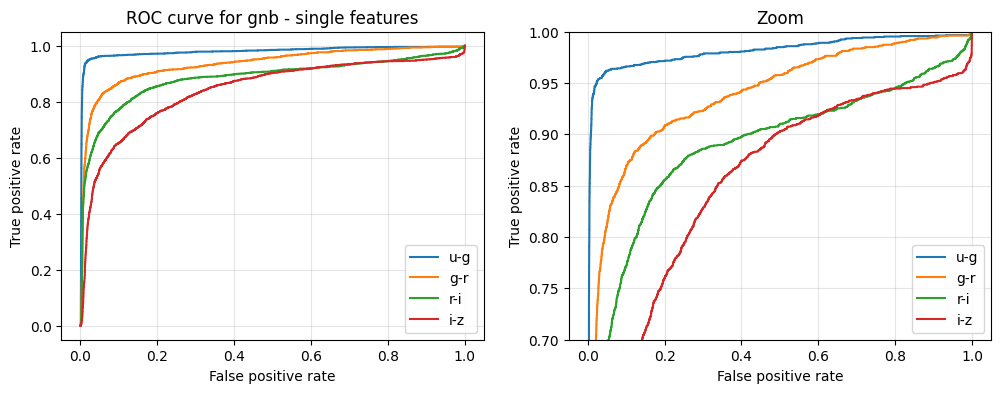

In [51]:
single_ROC(X_train, X_test, y_train, y_test, 'gnb')

So, as suspected, the most informative feature is the $(u-g)$ one. Let's plot the ROC curves for the classificator trained on different numbers of features:

Training the data with multiple features:



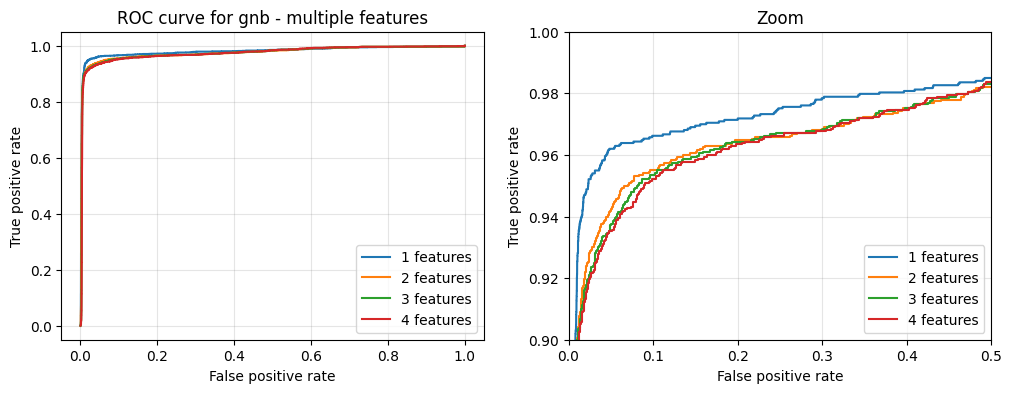

In [52]:
progressive_ROC(X_train, X_test, y_train, y_test, 'gnb')

This plot tells us that just the $(u-g)$ feature is enough to classify the dataset. 

We can now plot the results on the data. As a comparison, we'll first use the classifier trained only on the $(u-g)$ feature, and then we'll train it on all the features. We'll plot as an example the classificarion results on the $(u-g)$ feature. 

The following graphs show:

- The predicted labels for the train dataset;
- The true labels for the train dataset;
- The predicted labels for the test dataset;
- The true labels for the test dataset.

#### Training on the $(u-g)$ feature


In [53]:
# TRAINING ON A SINGLE FEATURE
gnb = GaussianNB()
gnb.fit(X_train[:, 0].reshape(-1, 1), y_train)

y_test_pred_gnb = gnb.predict(X_test[:, 0].reshape(-1, 1))
y_train_pred_gnb = gnb.predict(X_train[:, 0].reshape(-1, 1))

CLASSIFIER TRAINED ON THE (u-g) FEATURE



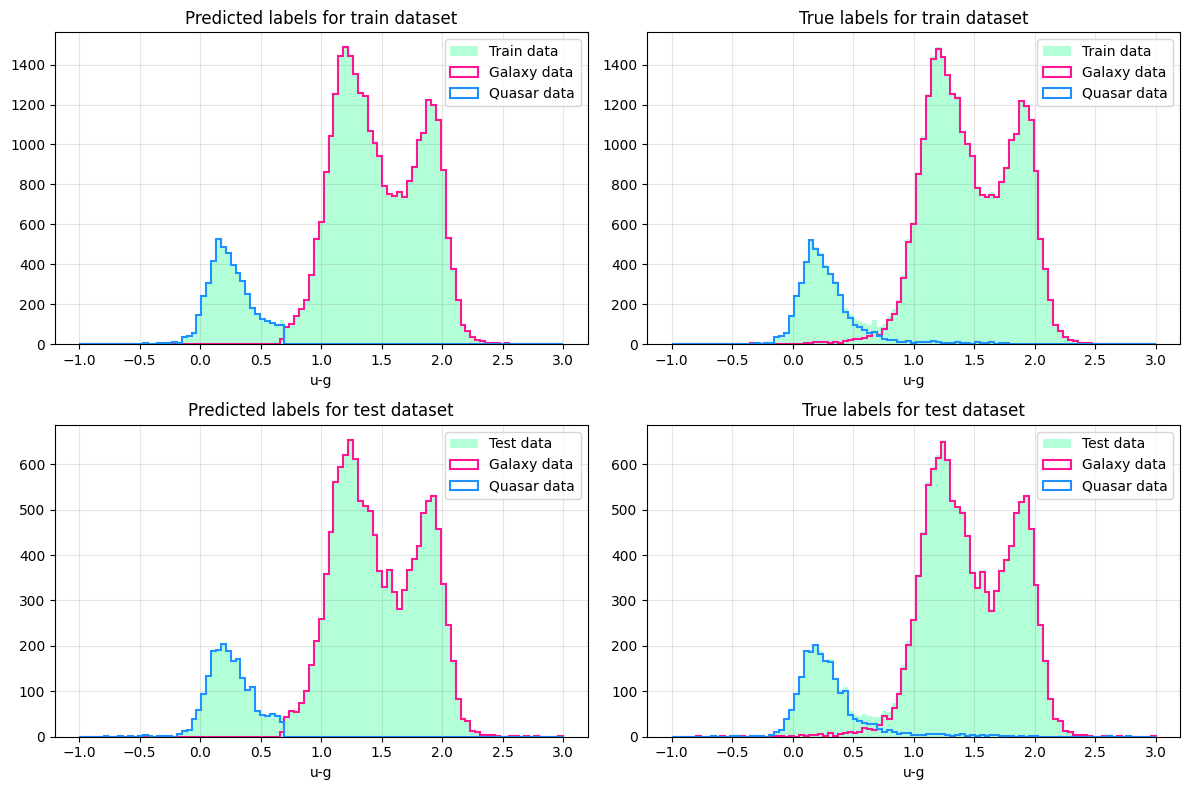

In [54]:
print('CLASSIFIER TRAINED ON THE (u-g) FEATURE\n')

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gnb, y_test_pred_gnb, 'u-g')

This shows that also some of the train data are mislabeled. Let's plot the confusion matrix for the train and test data:

In [72]:
print("Accuracy of the prediction on the train data: %.5f" % accuracy_score(y_train, y_train_pred_gnb))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_gnb))

print("\nAccuracy of the prediction on the test data: %.5f" % accuracy_score(y_test, y_test_pred_gnb))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_gnb))

Accuracy of the prediction on the train data: 0.98109
Confusion matrix for the train data:
[[29688   309]
 [  353  4650]]

Accuracy of the prediction on the test data: 0.98060
Confusion matrix for the test data:
[[12738   131]
 [  160  1971]]


We can plot the mismatched datapoints, for example, in the $(u-g) - (g-r)$ plane:

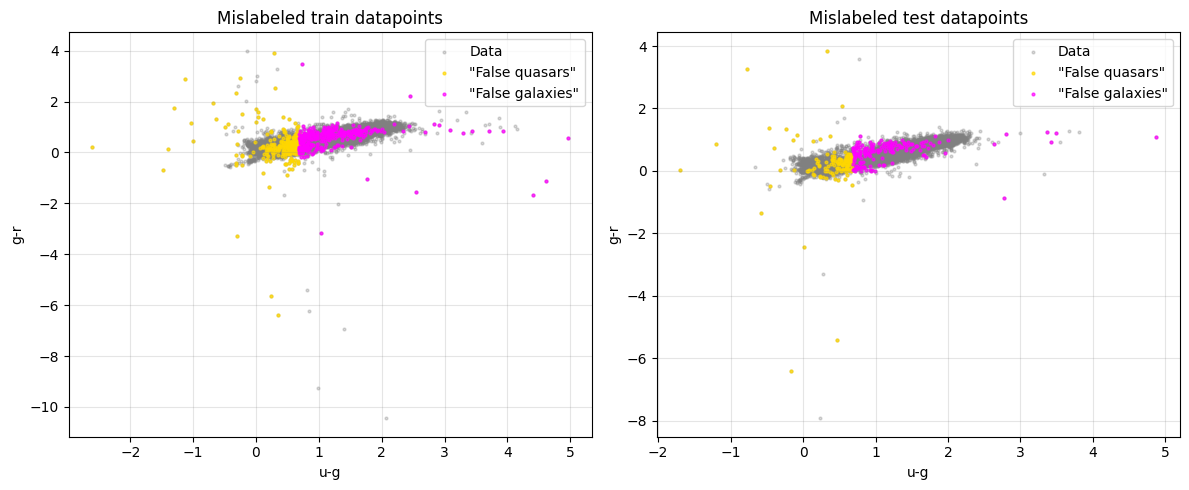

In [56]:
mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gnb, y_test_pred_gnb, 'u-g', 'g-r')

So, the datapoints in the tails of the two distributions are mislabeled; this is not surprising.

Let's repeat the whole process, this time training the classifier on all the features:

#### Training on all features


CLASSIFIER TRAINED ON ALL THE FEATURES



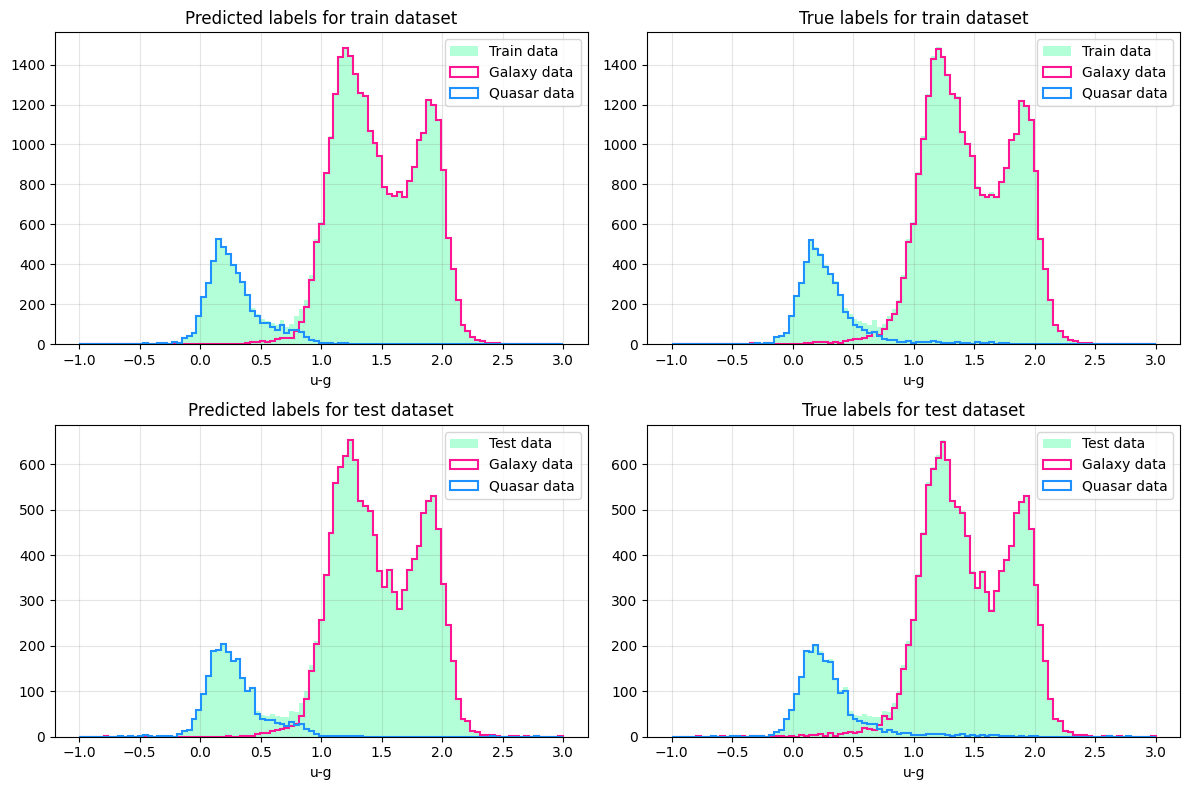

Accuracy of the prediction on the train data: 0.973
Confusion matrix for the train data:
[[29409   588]
 [  369  4634]]

Accuracy of the prediction on the test data: 0.970
Confusion matrix for the test data:
[[12611   258]
 [  185  1946]]


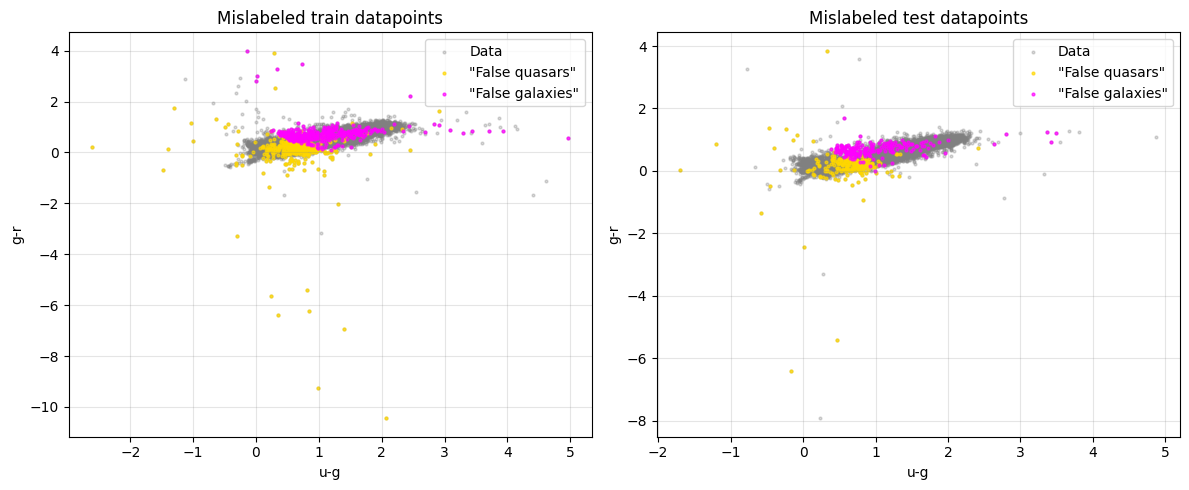

In [57]:
# TRAINING ON ALL THE FEATURES
gnb_tot = GaussianNB()
gnb_tot.fit(X_train, y_train)

y_test_pred_gnb_tot = gnb_tot.predict(X_test)
y_train_pred_gnb_tot = gnb_tot.predict(X_train)


print('CLASSIFIER TRAINED ON ALL THE FEATURES\n')

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gnb_tot, y_test_pred_gnb_tot, 'u-g')


print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_gnb_tot))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_gnb_tot))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_gnb_tot))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_gnb_tot))


mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gnb_tot, y_test_pred_gnb_tot, 'u-g', 'g-r')

As predicted by the ROC curves, the classifier trained only on the $(u-g)$ performs better.


## Quadratic Discriminant Analysis

Let's try now using a QDA classification. As before, we'll first plot the ROC curves:

Training the data with a single feature:



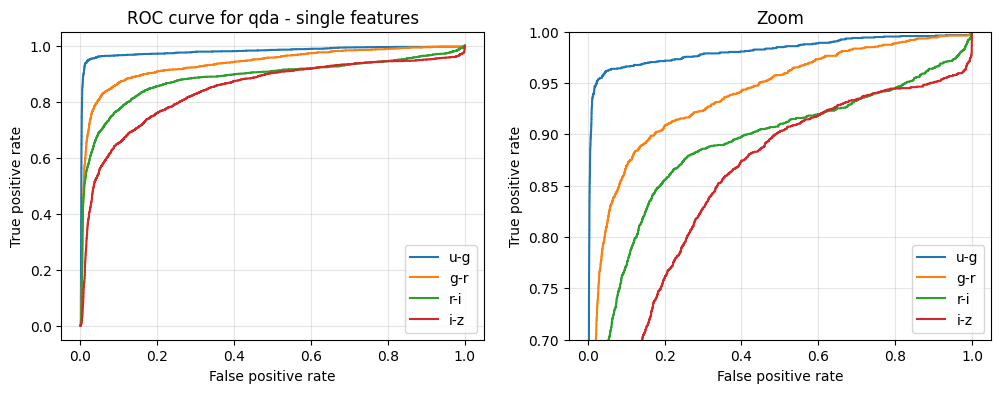

Training the data with multiple features:



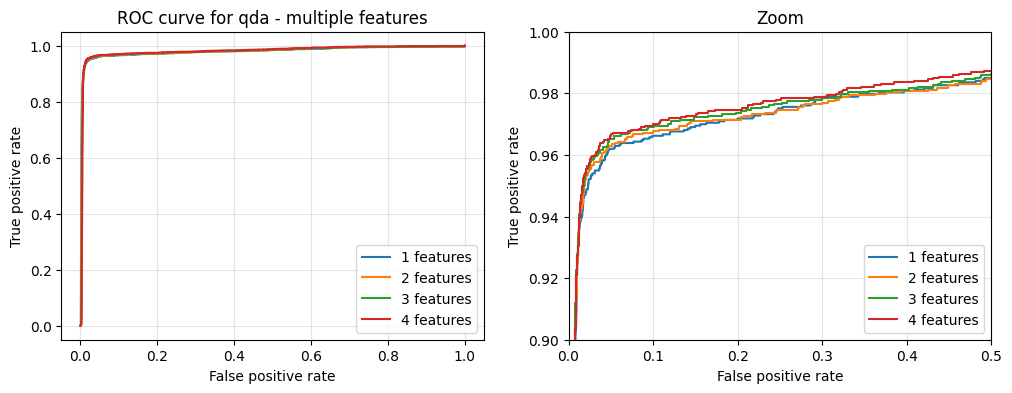

In [66]:
single_ROC(X_train, X_test, y_train, y_test, 'qda')
progressive_ROC(X_train, X_test, y_train, y_test, 'qda')

The first plots look identical to the ones seen for the Naive Bayes classifier, while the ROC curves for the classifier trained on all the features are different. Let's see the results:

#### Training on the $(u-g)$ feature

Does this classifier yield the same results as the GNB (trained on $(u-g)$) one?

In [71]:
# TRAINING ON THE (u-g) FEATURE
qda = QDA()
qda.fit(X_train[:, 0].reshape(-1, 1), y_train)

y_test_pred_qda = qda.predict(X_test[:, 0].reshape(-1, 1))
y_train_pred_qda = qda.predict(X_train[:, 0].reshape(-1, 1))

print("Accuracy of the prediction on the train data: %.5f" % accuracy_score(y_train, y_train_pred_qda))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_qda))

print("\nAccuracy of the prediction on the test data: %.5f" % accuracy_score(y_test, y_test_pred_qda))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_qda))

Accuracy of the prediction on the train data: 0.98109
Confusion matrix for the train data:
[[29688   309]
 [  353  4650]]

Accuracy of the prediction on the test data: 0.98060
Confusion matrix for the test data:
[[12738   131]
 [  160  1971]]


In [68]:
# Are they exactly the same??
print(np.array_equal(y_test_pred_qda, y_test_pred_gnb))
print(np.array_equal(y_train_pred_qda, y_train_pred_gnb))

True
True


So yes, the QDA classifier yields the same results ar the GNB one, if trained on the single $(u-g)$ feature. Let's see how it performs if trained on all the features:

#### Training on all the features


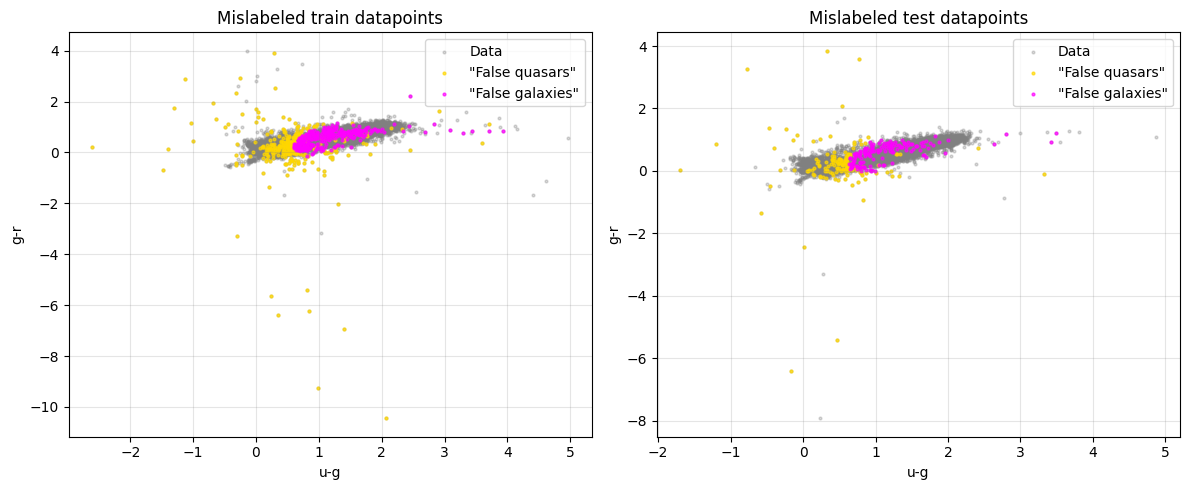

Accuracy of the prediction on the train data: 0.981
Confusion matrix for the train data:
[[29659   338]
 [  343  4660]]

Accuracy of the prediction on the test data: 0.980
Confusion matrix for the test data:
[[12725   144]
 [  149  1982]]


In [69]:
# TRAINING ON ALL THE FEATURES
qda_tot = QDA()
qda_tot.fit(X_train, y_train)

y_test_pred_qda_tot = qda_tot.predict(X_test)
y_train_pred_qda_tot = qda_tot.predict(X_train)

#plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_qda_tot, y_test_pred_qda_tot, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_qda_tot, y_test_pred_qda_tot, 'u-g', 'g-r')

print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_qda_tot))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_qda_tot))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_qda_tot))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_qda_tot))

In this case, the results are different, and the QDA performed better than the GNB (see end of the code for a summary of the results).

So, if before the best classifier was the gnb one trained only on a single feature, in this case the best one is the one trained on all features.


## GMM Bayes Classifier



## K-nearest neighbors classifier


In [ ]:
# OTHERS???? POSSIBILE CANDIDATO ALLA DOMANDA A PIACERE!

In [ ]:
from astroML.utils import completeness_contamination

accuracy_train_gnb = accuracy_score(y_train, train_pred_gnb)
accuracy_test_gnb = accuracy_score(y_test, test_pred_gnb)

print('The accuracy of the training set is:', accuracy_train_gnb)
print('The accuracy of the test set is:', accuracy_test_gnb)

cm_train_gnb = confusion_matrix(y_train, train_pred_gnb)
cm_test_gnb = confusion_matrix(y_test, test_pred_gnb)

print('\n Confusion matrix of the training set: \n',  cm_train_gnb)
print('\n Confusion matrix of the test set: \n',  cm_test_gnb)

completeness_gnb, contamination_gnb = completeness_contamination(test_pred_gnb, y_test)

print("\ncompleteness", round(float(completeness_gnb),3))
print("contamination", round(float(contamination_gnb),3))

In [ ]:
# FAI SUMMARY

In [ ]:
# COSA SIGNIFICA LA STORIA DELLA NAIVE ASSUMPTION NELLE RICHIESTE????
# PERCHE' QDA E GNB DANNO LO STESSO RISULTATO PER IL CLASSIFIER TRAINED SU UNA SOLA FEATURE?